# Titanic

References for this notebook are:
1. [Fast.ai Lesson 5](https://course.fast.ai/Lessons/lesson5.html)
2. [Accompanying Kaggle notebook](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch/notebook)

Major difference between this notebook and the reference one:
1. Using Tensorflow (instead of FastAI/PyTorch) to create the models
  * Using `GradientTape` instead of PyTorch's automatic differentiation tool

Further inspiration is from this blog:
1. [Machine Learning for Beginners: An Introduction to Neural Networks](https://victorzhou.com/blog/intro-to-neural-networks/)

## Download dataset

In [1]:
import os
from google.colab import userdata

os.environ['KAGGLE_USERNAME'] = 'kevvo83'
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY') # Add the KAGGLE_KEY secret to google colab secrets

In [3]:
import zipfile, kaggle
from pathlib import Path

path_s: str = 'titanic'
path = Path(path_s)
kaggle.api.competition_download_cli(path_s)
zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 34.1k/34.1k [00:00<00:00, 19.7MB/s]

In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

In [8]:
!head /content/titanic/train.csv

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S


## Prepare training dataset and label

In [38]:
df = pd.read_csv(os.path.join('/content', 'titanic', 'train.csv'))
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [39]:
df.info()

# 891 records in total

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Describe all numerical fields

In [40]:
df.describe(include=[np.number])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Describe all non-numerical fields

In [41]:
df.describe(include=[object])

df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [24]:
df.isna().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >, <Axes: >]],
      dtype=object)

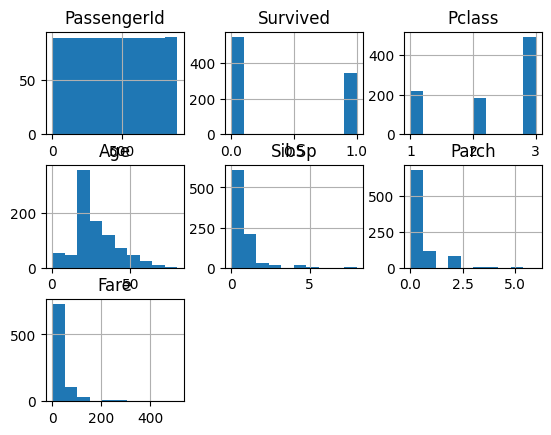

In [63]:
df.hist()

### Data observations

Observations:

1. Fare has a very long tail - a median of 14 to a max of 500 - we will use `np.log` to squish these values down
2. Following columns are categorical columns:
  * Survived (0/1) - this is the label though, so ignore for now
  * PClass (1/2/3)
  * Embarked (s/c/q)
  * Sex (m/f)


Data pre-processing:

1. Squish/Normalize the fare values
2. One-hot encode the following categorical fields:
  * PClass
  * Embarked
  * Sex




### Data pre-processing



#### Fill NaN fields

In [42]:
most_common_cabin = df.mode(axis=0, dropna=True).iloc[0].loc['Cabin']
most_common_age   = df.mode(axis=0, dropna=True).iloc[0].loc['Age']
most_common_embarked   = df.mode(axis=0, dropna=True).iloc[0].loc['Embarked']

df.fillna({'Cabin': most_common_cabin, 'Age': most_common_age, 'Embarked': most_common_embarked}, inplace=True)
df.isna().sum(axis=0)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

#### One-hot encoding categorical data fields

In [43]:
df = pd.get_dummies(df, columns=['Pclass', 'Embarked', 'Sex'], dtype='int64')
df

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B96 B98,0,0,1,0,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,0,1,0,0,1,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,0,0,1,0,0,1,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,0,1,1,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B96 B98,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,B96 B98,0,1,0,0,0,1,0,1
887,888,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,B42,1,0,0,0,0,1,1,0
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",24.0,1,2,W./C. 6607,23.4500,B96 B98,0,0,1,0,0,1,1,0
889,890,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,C148,1,0,0,1,0,0,0,1


#### Squishing the Fare numerical data field

In [ ]:
df['Fare'] = np.log(df['Fare'] + 1)

#### Squishing the Age numerical data field

In [106]:
df['Age'] = df['Age'] / df['Age'].max()

#### Visualizing the dataset fields post pre-processsing

array([[<Axes: title={'center': 'PassengerId'}>,
        <Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>,
        <Axes: title={'center': 'Pclass_1'}>,
        <Axes: title={'center': 'Pclass_2'}>],
       [<Axes: title={'center': 'Pclass_3'}>,
        <Axes: title={'center': 'Embarked_C'}>,
        <Axes: title={'center': 'Embarked_Q'}>,
        <Axes: title={'center': 'Embarked_S'}>],
       [<Axes: title={'center': 'Sex_female'}>,
        <Axes: title={'center': 'Sex_male'}>, <Axes: >, <Axes: >]],
      dtype=object)

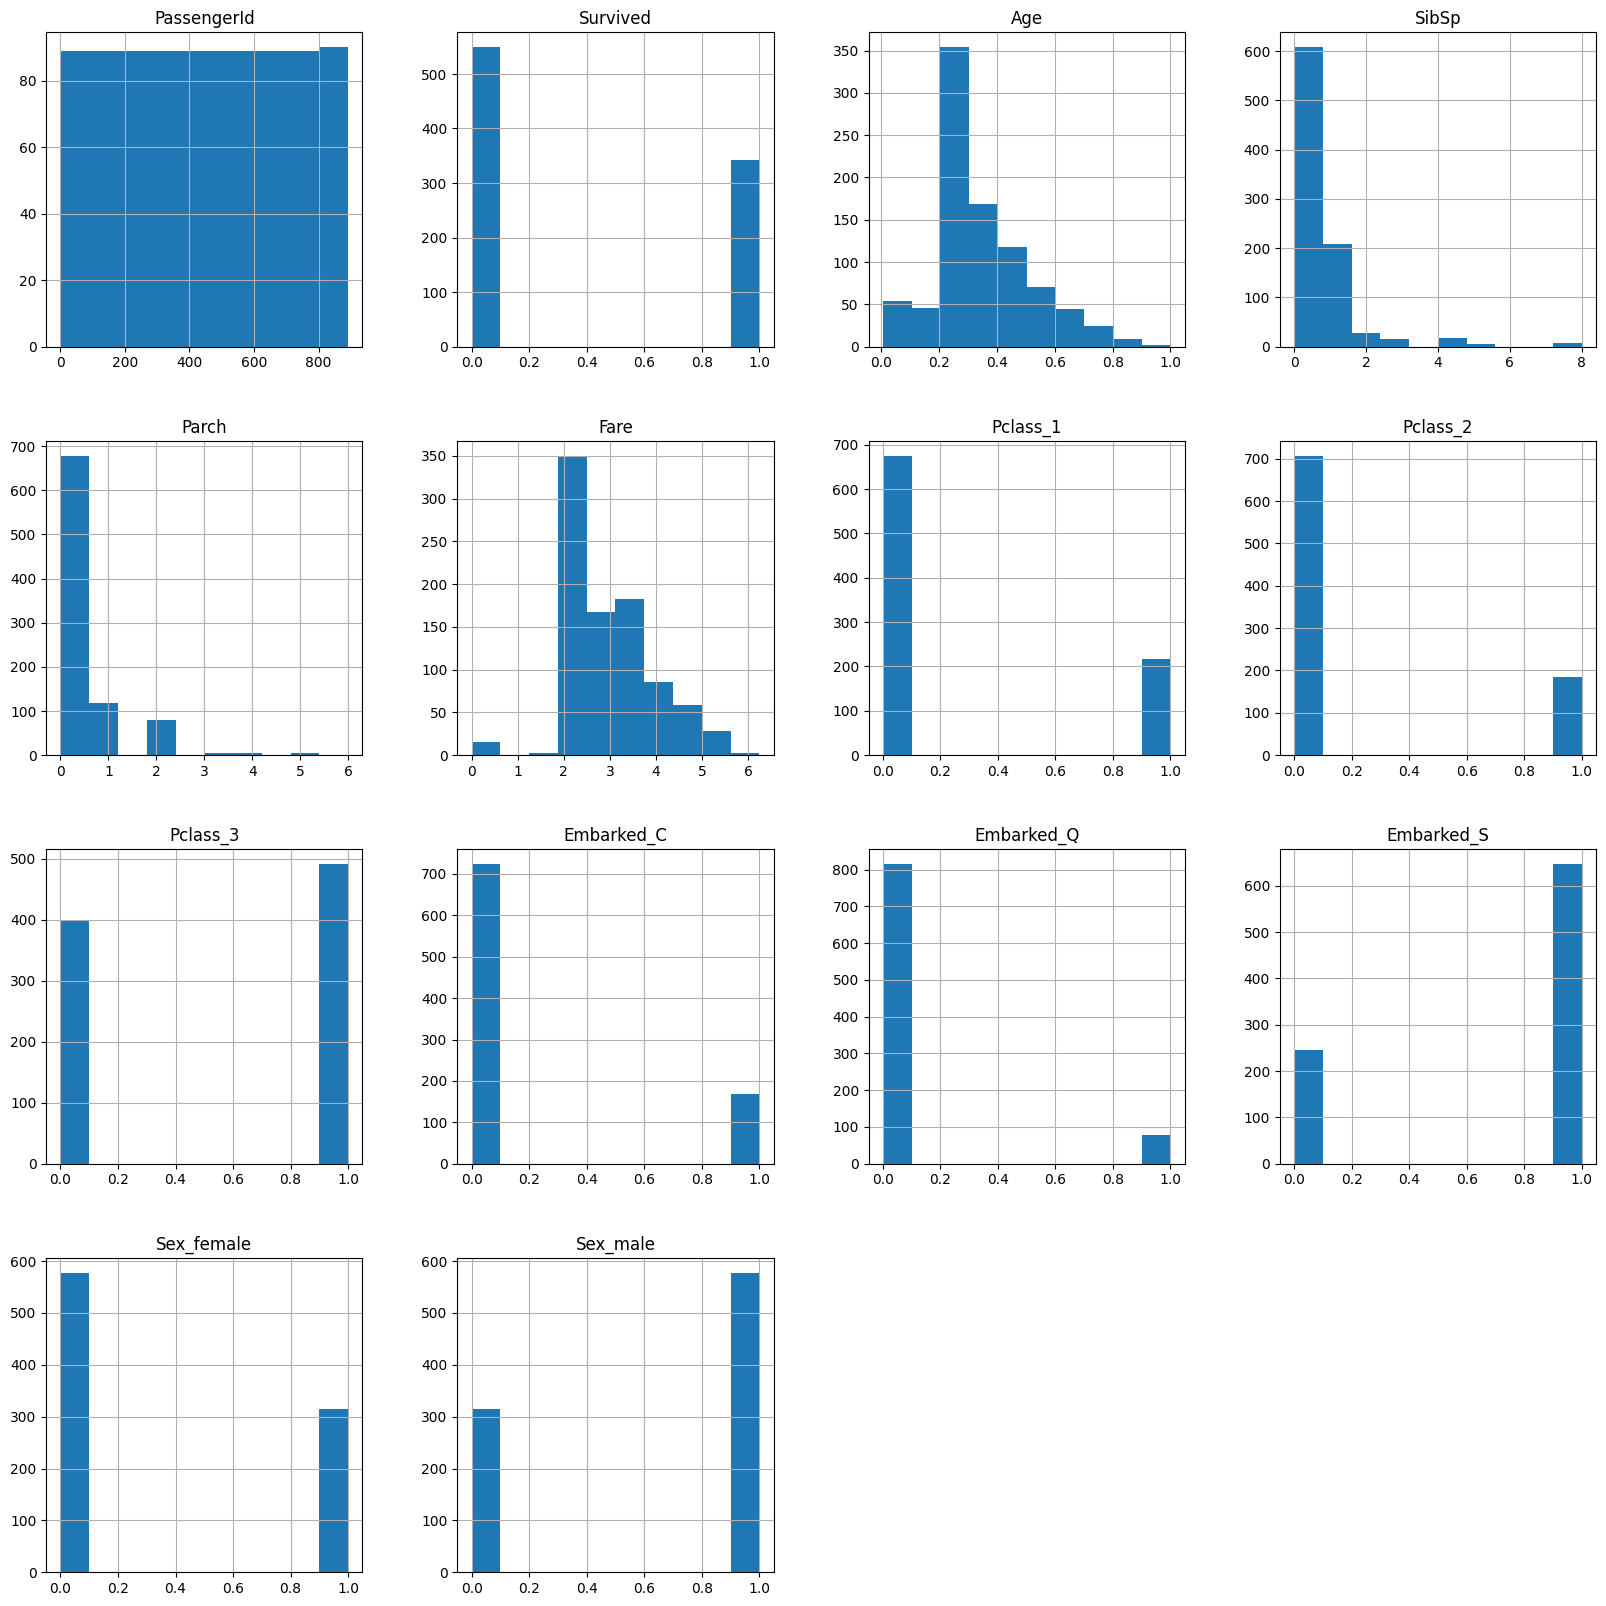

In [108]:
df.hist(figsize=(20,20))

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Name         891 non-null    object 
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Ticket       891 non-null    object 
 7   Fare         891 non-null    float64
 8   Cabin        891 non-null    object 
 9   Pclass_1     891 non-null    int64  
 10  Pclass_2     891 non-null    int64  
 11  Pclass_3     891 non-null    int64  
 12  Embarked_C   891 non-null    int64  
 13  Embarked_Q   891 non-null    int64  
 14  Embarked_S   891 non-null    int64  
 15  Sex_female   891 non-null    int64  
 16  Sex_male     891 non-null    int64  
dtypes: float64(2), int64(12), object(3)
memory usage: 118.5+ KB


### Prepare training & validation data and labels

In [110]:
df[c].describe()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.357087,0.523008,0.381594,2.962246,0.242424,0.206510,0.551066,0.188552,0.086420,0.725028,0.352413,0.647587
std,0.164995,1.102743,0.806057,0.969048,0.428790,0.405028,0.497665,0.391372,0.281141,0.446751,0.477990,0.477990
min,0.005250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.275000,0.000000,0.000000,2.187218,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.300000,0.000000,0.000000,2.737881,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,0.437500,1.000000,0.000000,3.465736,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,8.000000,6.000000,6.240917,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [111]:
c = ['Age', 'SibSp', 'Parch',
     'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
     'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male']

dataset = tf.convert_to_tensor(df[c])
labels = tf.convert_to_tensor(df['Survived'])

print(dataset.shape)
print(labels.shape)

(891, 12)
(891,)


In [49]:
dataset

<tf.Tensor: shape=(891, 12), dtype=float64, numpy=
array([[22.,  1.,  0., ...,  1.,  0.,  1.],
       [38.,  1.,  0., ...,  0.,  1.,  0.],
       [26.,  0.,  0., ...,  1.,  1.,  0.],
       ...,
       [24.,  1.,  2., ...,  1.,  1.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       [32.,  0.,  0., ...,  0.,  0.,  1.]])>

In [129]:
X_train, X_val, y_train, y_val = train_test_split(dataset.numpy(), labels.numpy(), test_size=0.2, random_state=42, shuffle=True)

X_train = tf.constant(X_train)
X_val = tf.constant(X_val)
y_train = tf.constant(y_train)
y_val = tf.constant(y_val)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(712, 12)
(179, 12)
(712,)
(179,)


In [130]:
X_train

<tf.Tensor: shape=(712, 12), dtype=float64, numpy=
array([[0.56875, 0.     , 0.     , ..., 1.     , 0.     , 1.     ],
       [0.2875 , 0.     , 0.     , ..., 1.     , 0.     , 1.     ],
       [0.4    , 0.     , 0.     , ..., 1.     , 0.     , 1.     ],
       ...,
       [0.5125 , 2.     , 0.     , ..., 1.     , 0.     , 1.     ],
       [0.175  , 1.     , 2.     , ..., 1.     , 1.     , 0.     ],
       [0.2625 , 0.     , 1.     , ..., 1.     , 0.     , 1.     ]])>

## Manually create the linear model

Code Linear Regression model from scratch

First step, manually intialize a random weights vector of size `(1,891)`

In [66]:
w = tf.random.uniform(
    shape=(1, X_train.shape[1]),
    minval=0,
    maxval=0.5,
    seed=42,
    dtype=tf.float64
)
w

<tf.Tensor: shape=(1, 12), dtype=float64, numpy=
array([[0.39038085, 0.08133741, 0.32818364, 0.40585311, 0.25819205,
        0.11737117, 0.47349255, 0.42263483, 0.36374439, 0.28038839,
        0.24050501, 0.18767444]])>

In [21]:
# Potentially use Gradient Tape to track the gradients automatically?
# The course uses this function called `requires_grad_` from pyTorch

with tf.GradientTape() as tape:

  tape.watch([w])

  y_hat = w @ tf.transpose(train_X)
  loss = tf.keras.losses.MSE(train_Y, y_hat)

  grad = tape.gradient(loss, w)

  assert grad.shape == w.shape

### Tensorflow GradientTape for automatic differentiation

In [175]:
def epoch_def(
    num_epochs: int,
    x: tf.Tensor,
    y: tf.Tensor,
    current_epoch: int,
    w: np.ndarray,
    lr: float,
    tape
  ) -> np.ndarray:

  with tape:
    tape.watch([w])

    if current_epoch > num_epochs:
      return w

    else:
      # This could be further taken out into a function called forward_pass
      y_hat = tf.math.sigmoid(w @ tf.transpose(x))
      loss = tf.keras.losses.MSE(y, y_hat)

      print(f'Epoch {current_epoch}/{num_epochs}, loss={loss}')

      # This could be further taken out into a function called backward pass
      grad = tape.gradient(loss, w) # dloss_dw

      assert grad.shape == w.shape

      w = w - (lr * grad)

      return epoch_def(num_epochs, x, y, current_epoch + 1, w, lr, tape)

### Define the model

In [176]:
## First step, manually intialize a random weights vector of size (1,891)

w = tf.random.uniform(
    shape=(1, X_train.shape[1]),
    minval=0,
    maxval=0.5,
    seed=42,
    dtype=tf.float64
)

## Initialize the gradient tape and inject it into the epoch_def function
tape = tf.GradientTape()

trained_weights = epoch_def(
                            num_epochs=50,
                            x=X_train,
                            y=y_train,
                            current_epoch=1,
                            w=w,
                            lr=0.2,
                            tape=tape
                          )

assert trained_weights.shape == (1, 12)

trained_weights.numpy()

Epoch 1/50, loss=[0.49336366]
Epoch 2/50, loss=[0.47490986]
Epoch 3/50, loss=[0.45238159]
Epoch 4/50, loss=[0.42530438]
Epoch 5/50, loss=[0.3939485]
Epoch 6/50, loss=[0.36005599]
Epoch 7/50, loss=[0.32709719]
Epoch 8/50, loss=[0.29901575]
Epoch 9/50, loss=[0.27798794]
Epoch 10/50, loss=[0.26360969]
Epoch 11/50, loss=[0.25409404]
Epoch 12/50, loss=[0.24765443]
Epoch 13/50, loss=[0.24303386]
Epoch 14/50, loss=[0.23946884]
Epoch 15/50, loss=[0.23652119]
Epoch 16/50, loss=[0.23394319]
Epoch 17/50, loss=[0.23159451]
Epoch 18/50, loss=[0.22939512]
Epoch 19/50, loss=[0.22729911]
Epoch 20/50, loss=[0.22528013]
Epoch 21/50, loss=[0.22332306]
Epoch 22/50, loss=[0.22141933]
Epoch 23/50, loss=[0.21956409]
Epoch 24/50, loss=[0.21775465]
Epoch 25/50, loss=[0.21598949]
Epoch 26/50, loss=[0.21426774]
Epoch 27/50, loss=[0.21258881]
Epoch 28/50, loss=[0.21095225]
Epoch 29/50, loss=[0.20935762]
Epoch 30/50, loss=[0.20780447]
Epoch 31/50, loss=[0.20629227]
Epoch 32/50, loss=[0.20482045]
Epoch 33/50, loss=

array([[-0.07822487, -0.12832271,  0.29583203, -0.21124247,  0.22591227,
         0.39361795, -0.30258345,  0.47389082,  0.38522296,  0.0834135 ,
         0.72757374, -0.22848508]])

### Predictions on the validation set

In [177]:
def calc_predictions(weights: np.ndarray, validation_ds: tf.Tensor) -> np.ndarray:
  return tf.math.sigmoid(weights @ tf.transpose(validation_ds))

y_hat_val = calc_predictions(trained_weights, X_val)

### Calculate accuracy

In [178]:
def calc_accuracy(y_hat: tf.Tensor, y_real: tf.Tensor) -> np.float64:
  validation_acc_result = (y_val == 1) == (y_hat > 0.5)
  accuracy = tf.reduce_sum(tf.cast(validation_acc_result, tf.int32)).numpy() / validation_acc_result.shape[1]
  return accuracy

print(f'Accuracy is {calc_accuracy(y_hat_val, y_val)}')

Accuracy is 0.7597765363128491


## Manually define the Neural Network